In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.options.plotting.backend = "plotly"
import os
from ipywidgets import interact, interactive, interact_manual
import ipywidgets as widgets
from IPython.display import display,HTML

In [4]:
path_analysis = 'results/bowtieANDmarkov'
states = ["ssc","in","out","tubes","tendrils","fringe","disconnected"]

df_raw = pd.read_json(os.path.join(path_analysis,'bt_comp_count.json'),convert_dates=True).transpose()
df_bowtie = df_raw.copy()

#clean df for sunken transactions
df_sunk = df_bowtie[list(map(lambda x: x+ '_s', states))]
df_sunk.columns = states
df_bowtie[states] = df_bowtie[states].subtract(df_sunk)

total_nodes = df_bowtie[states].sum(axis=1)


In [5]:
#absolut number of nodes in components
range_slider = widgets.SelectionRangeSlider(
    options=df_bowtie.index.date, index=(0, len(df_bowtie.index)-1),
    description='Date window', orientation='horizontal', layout={'width': '500px'})

mean_slider = widgets.IntSlider(min=1, max=100, step=1, value=10, 
                                        description='rolling mean')

@interact #@interact_manual
def plot_bt_abs(rolling_mean = mean_slider, date_range = range_slider, scale=['absolute','relative']):
    df_comp = df_bowtie.copy().loc[date_range[0]:date_range[1]][states]
    df_comp.columns.name = 'Bow-tie component'
    if scale == 'relative':
        df_comp = df_comp.div(df_comp.sum(axis=1).values,axis=0)
    df_comp.rolling(window=rolling_mean).mean().plot(title="bow-tie components {}".format(scale)).show()
    
#display(HTML("<style>div.output_scroll { height: 50em; }</style>"))
#interact(plot_bt_abs, window= widgets.IntSlider(min=1, max=100, step=1, value=10))



interactive(children=(IntSlider(value=10, description='rolling mean', min=1), SelectionRangeSlider(description…

In [6]:
#  load markov transition matrices
file = os.path.join(path_analysis, "transition_matrices.json")
states_extened = states + ['inactive']

with open(file, 'r') as tm_file:
    data = tm_file.read()

transition_dict = json.loads(data)

In [7]:
# Show markov transition matrix
range_slider2 = widgets.SelectionRangeSlider(
    options=df_bowtie.index.date, index=(0, len(df_bowtie.index)-1),
    description='Date window', orientation='horizontal', layout={'width': '500px'})

@interact #@interact_manual
def transition_matrix(date_range = range_slider, scale=['relative','absolute'],exclude_inactive=False):
    
    date_from , date_to = date_range[0].strftime('%Y-%m-%d'), date_range[1].strftime('%Y-%m-%d')
    tm_matrix = np.zeros(shape=(len(states_extened),len(states_extened)),dtype=int)
    
    date_index = pd.DataFrame({},index=transition_dict.keys())
    keys = date_index.loc[date_from : date_to].index.values
    
    for key in keys:
        tm = transition_dict[key]
        tm_matrix += np.array(np.array(tm))

    df = pd.DataFrame(tm_matrix, index=states_extened, columns=states_extened)
    
    if exclude_inactive == True:
        df = df[states][:-1]
    rep = "{}"
    if scale == 'relative':
       df = df.div(df.sum(axis=1).values,axis=0)
       rep = "{:.2%}"
    display(df.style.background_gradient(cmap='Blues').format(rep)
            .set_caption("Markov state transition matrix for {} to {} in {} numbers"
                         .format(date_from, date_to, scale)))


interactive(children=(SelectionRangeSlider(description='Date window', index=(0, 3460), layout=Layout(width='50…

In [8]:
range_slider3 = widgets.SelectionRangeSlider(
    options=df_bowtie.index.date, index=(0, len(df_bowtie.index)-1),
    description='Date window', orientation='horizontal', layout={'width': '500px'})

@interact #@interact_manual
def tm_barplot(date_range = range_slider3, scale=['relative','absolute'],
               state = states_extened,exclude_inactive=True ):
    
    date_from , date_to = date_range[0].strftime('%Y-%m-%d'), date_range[1].strftime('%Y-%m-%d')
    tm_matrix = np.zeros(shape=(len(states_extened),len(states_extened)),dtype=int)
    
    date_index = pd.DataFrame({},index=transition_dict.keys())
    keys = date_index.loc[date_from : date_to].index.values
    
    for key in keys:
        tm = transition_dict[key]
        tm_matrix += np.array(np.array(tm))

    df = pd.DataFrame(tm_matrix, index=states_extened, columns=states_extened)
    if exclude_inactive == True:
        df = df[states][:-1]
    if scale == 'relative':
        df = df.div(df.sum(axis=1).values,axis=0)*100
        
    df_bar = df.loc[state] #[["ssc","in","out"]].transpose()
    fig = df_bar.plot.bar(title='probability to be in the different states in T+1 if the node is in state {} at time T'
                    .format(state))
    fig.update_layout(barmode='group')
    fig.show()
    

interactive(children=(SelectionRangeSlider(description='Date window', index=(0, 3460), layout=Layout(width='50…

In [9]:
tm_matrix = np.zeros(shape=(len(states_extened),len(states_extened)),dtype=int)

date_index = pd.DataFrame({},index=transition_dict.keys())
keys = date_index.index.values
tm_time = {"ssc":[],"in":[],"out":[],"tubes":[],"tendrils":[],"fringe":[],"disconnected":[]}
ratio = []
for key in keys:
    tm = transition_dict[key]
    for i, state in enumerate(states):
        tm_time[state].append(tm[i])
    tm_matrix += np.array(np.array(tm))
    df = pd.DataFrame(tm_matrix, index=states_extened, columns=states_extened)
    tot_nodes = df.sum().sum()
    if df[states][:-1].sum().sum() == 0:
        ratio.append(0)
    else:
        ratio.append(df.sum().sum() / df[states][:-1].sum().sum())
    

ratio_common_nodes = pd.DataFrame({'ratio_common_nodes':ratio}, index=keys)


In [10]:
dropout = pd.DataFrame({'dropout rate':[100-x for x in ratio]}, index=keys)
fig = dropout.plot(title = 'Markov Analysis: Ratio of Nodes that are inactive in either G(T) or G(T+1)')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

In [11]:
mean_slider2 = widgets.IntSlider(min=1, max=100, step=1, value=10, 
                                        description='rolling mean')

@interact #@interact
def plot_bt_abs(state=states, rolling_mean=mean_slider2):
    df = pd.DataFrame(tm_time[state], index=keys, columns=states_extened)
    df = df[states].div(df[states].sum(axis=1).values,axis=0)*100
    df[states].rolling(window=rolling_mean).mean().loc['2013':].plot(
    title='markov state probability for T+1 over time if at time T the node is in state {}'.format(state)).show()



interactive(children=(Dropdown(description='state', options=('ssc', 'in', 'out', 'tubes', 'tendrils', 'fringe'…

In [12]:
# plot basic stats
df = pd.read_json("results/randomizedANDstats/btc_stats.json",convert_dates=True)
df = df.sort_values(by=['date'])

In [13]:
df.head()

,g_nodes,g_edges,g_density,std_in,std_out,skew_in,skew_out,date
0,6114,7393,0.000198,2.918908,16.756162,24.952172,55.430982,2012-01-01
7,6397,7369,0.000180,3.557525,15.354761,33.913128,58.683482,2012-01-02
10,6699,8023,0.000179,3.774909,17.153680,39.156222,59.694470,2012-01-03
2,6795,7977,0.000173,4.121667,15.973499,54.531903,62.550639,2012-01-04
11,7865,9243,0.000149,4.423117,16.588703,47.701865,64.021523,2012-01-05


In [14]:
def rolling(series,rolling_days):
    return series.rolling(window=rolling_days).mean()

df_rolling = rolling(df,30).join(df['date'])

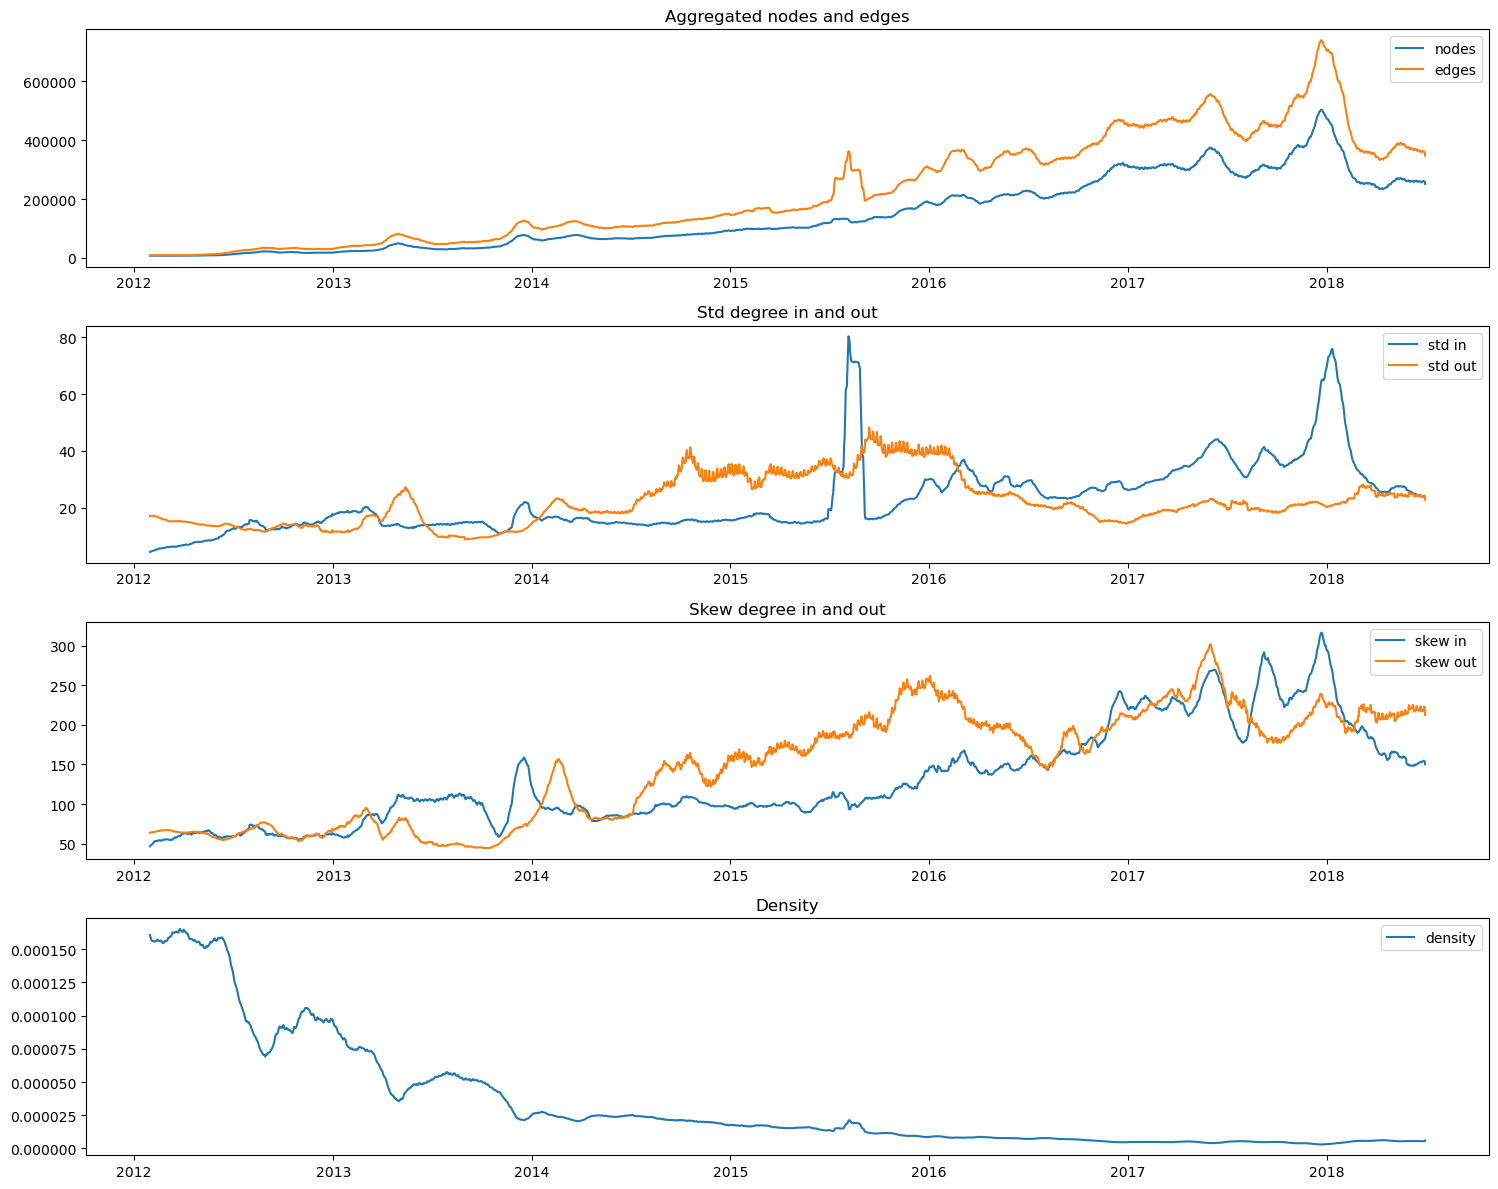

In [15]:
#sns.set_theme()

def stats_plots(df):
    fig, ((ax1, ax2,ax3,ax4)) = plt.subplots(4, 1,dpi=100)
    fig.set_size_inches(15,12)

    ax1.plot(df["date"],df["g_nodes"], label="nodes")
    ax1.plot(df["date"],df["g_edges"], label="edges")
    ax1.legend()
    ax1.set_title("Aggregated nodes and edges")

    ax2.plot(df["date"],df["std_in"], label="std in")
    ax2.plot(df["date"],df["std_out"], label="std out")
    ax2.legend()
    ax2.set_title("Std degree in and out")

    ax3.plot(df["date"],df["skew_in"], label="skew in")
    ax3.plot(df["date"],df["skew_out"], label="skew out")
    ax3.legend()
    ax3.set_title("Skew degree in and out")

    ax4.plot(df["date"],df["g_density"], label="density")
    ax4.legend()
    ax4.set_title("Density")

    plt.tight_layout()
    plt.show()
    
stats_plots(df_rolling)

In [16]:
df_rand1 = pd.read_json("results/randomizedANDstats/averaged_final/randomized_2012.json",convert_dates=True)
df_rand2 = pd.read_json("results/randomizedANDstats/averaged_final/randomized_2013.json",convert_dates=True)
df_rand3 = pd.read_json("results/randomizedANDstats/averaged_final/randomized_2014.json",convert_dates=True)
df_rand4 = pd.read_json("results/randomizedANDstats/averaged_final/randomized_2015.json",convert_dates=True)

In [17]:
data_rand = {
    "2012 basic":df_rand1["bowtie"][1:-2],
    "2012 random":df_rand1["bowtie_random"][1:-2],
    "2013 basic":df_rand2["bowtie"][1:-2],
    "2013 random":df_rand2["bowtie_random"][1:-2],
    "2014 basic":df_rand3["bowtie"][1:-2],
    "2014 random":df_rand3["bowtie_random"][1:-2],
    "2015 basic":df_rand4["bowtie"][1:-2],
    "2015 random":df_rand4["bowtie_random"][1:-2],
}

df_rand = pd.DataFrame(data_rand)

data_stats = {
    "2012":df_rand1["bowtie"][-2:],
    "2013":df_rand2["bowtie"][-2:],
    "2014":df_rand3["bowtie"][-2:],
    "2015":df_rand4["bowtie"][-2:],
}

df_stats = pd.DataFrame(data_stats).transpose()

data_stats_random = {
    "2012":df_rand1["bowtie_random"][-2:],
    "2013":df_rand2["bowtie_random"][-2:],
    "2014":df_rand3["bowtie_random"][-2:],
    "2015":df_rand4["bowtie_random"][-2:],
}

df_random_stats = pd.DataFrame(data_stats_random).transpose()

combined_data = {
    "clustering_basic": df_stats["clustering"],
    "clustering_random": df_random_stats["clustering"],
    "assortativity_basic": df_stats["assortativity"],
    "assortativity_random": df_random_stats["assortativity"]
}

df_combined_stats = pd.DataFrame(combined_data)

In [18]:
df_rand

,2012 basic,2012 random,2013 basic,2013 random,2014 basic,2014 random,2015 basic,2015 random
ssc,115.0,5.4,1540.0,107.4,11123.0,4373.4,10892.0,4827.8
in,1062.0,10.6,4310.0,3275.2,9314.0,3162.2,18492.0,8972.4
out,202.0,1674.6,1220.0,656.6,8090.0,22661.8,16940.0,17582.4
tubes,65.0,26.6,215.0,890.0,269.0,1183.6,592.0,3058.8
tendrils,3211.0,821.0,5629.0,6783.6,14093.0,7767.8,11188.0,16467.4
fringe,357.0,1528.6,2976.0,2923.6,383.0,2370.4,934.0,4694.8
disconnected,1102.0,2047.2,1844.0,3097.6,3186.0,4938.8,4200.0,7634.4


In [19]:
df_combined_stats

,clustering_basic,clustering_random,assortativity_basic,assortativity_random
2012,0.022651,0.008270,-0.166781,0.268354
2013,0.063061,0.001682,-0.156981,0.582647
2014,0.033727,0.001245,-0.117220,0.601907
2015,0.032228,0.000475,-0.106500,0.763234


In [20]:
df_degree1 = pd.read_json("results/degree_distribution/2012-01-01.json",convert_dates=True)
df_degree2 = pd.read_json("results/degree_distribution/2013-01-01.json",convert_dates=True)
df_degree3 = pd.read_json("results/degree_distribution/2014-01-01.json",convert_dates=True)
df_degree4 = pd.read_json("results/degree_distribution/2015-01-01.json",convert_dates=True)
df_degree5 = pd.read_json("results/degree_distribution/2016-01-01.json",convert_dates=True)
df_degree6 = pd.read_json("results/degree_distribution/2017-01-01.json",convert_dates=True)
df_degree7 = pd.read_json("results/degree_distribution/2018-01-01.json",convert_dates=True)

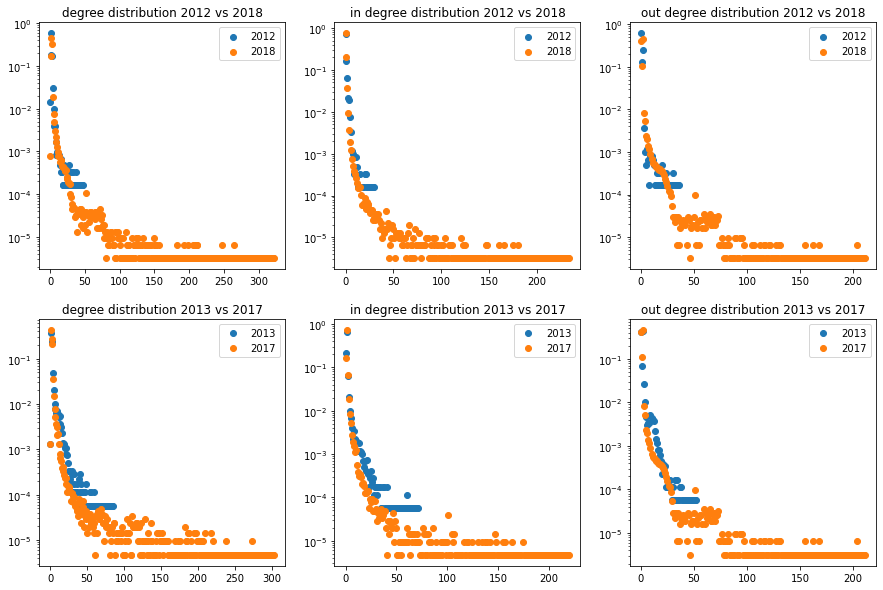

In [21]:
fig, axes = plt.subplots(2,3,figsize=(15,10))

axes[0][0].scatter(df_degree1['regular'][0],df_degree1['regular'][1],label="2012")
axes[0][0].scatter(df_degree7['regular'][0],df_degree7['regular'][1], label="2018")
axes[0][0].set_yscale('log')
axes[0][0].legend()
axes[0][0].set_title("degree distribution 2012 vs 2018")

axes[0][1].scatter(df_degree1['in'][0],df_degree1['in'][1],label="2012")
axes[0][1].scatter(df_degree7['in'][0],df_degree7['in'][1], label="2018")
axes[0][1].set_yscale('log')
axes[0][1].legend()
axes[0][1].set_title("in degree distribution 2012 vs 2018")

axes[0][2].scatter(df_degree1['out'][0],df_degree1['out'][1],label="2012")
axes[0][2].scatter(df_degree7['out'][0],df_degree7['out'][1], label="2018")
axes[0][2].set_yscale('log')
axes[0][2].legend()
axes[0][2].set_title("out degree distribution 2012 vs 2018")

axes[1][0].scatter(df_degree2['regular'][0],df_degree2['regular'][1],label="2013")
axes[1][0].scatter(df_degree6['regular'][0],df_degree6['regular'][1], label="2017")
axes[1][0].set_yscale('log')
axes[1][0].legend()
axes[1][0].set_title("degree distribution 2013 vs 2017")

axes[1][1].scatter(df_degree2['in'][0],df_degree2['in'][1],label="2013")
axes[1][1].scatter(df_degree6['in'][0],df_degree6['in'][1], label="2017")
axes[1][1].set_yscale('log')
axes[1][1].legend()
axes[1][1].set_title("in degree distribution 2013 vs 2017")

axes[1][2].scatter(df_degree2['out'][0],df_degree2['out'][1],label="2013")
axes[1][2].scatter(df_degree7['out'][0],df_degree7['out'][1], label="2017")
axes[1][2].set_yscale('log')
axes[1][2].legend()
axes[1][2].set_title("out degree distribution 2013 vs 2017")

plt.show()